# Stimulation 1 (biphasic with fractal amplitude, oscillatory amplitude, components)

In [ ]:
import numpy as np
import time
from neuroplatform import StimShape, StimParam, IntanSoftware, Trigger, Experiment, StimPolarity
from fbm import FBM

# Function to generate an oscillatory sequence (e.g., alpha rhythm)
def generate_oscillatory_sequence(length, frequency, min_amplitude, max_amplitude):
    t = np.linspace(0, 1, length)
    oscillatory_sequence = min_amplitude + (max_amplitude - min_amplitude) * np.sin(2 * np.pi * frequency * t)
    return oscillatory_sequence

def generate_fbmn_sequence(length, hurst, initial_scale, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Create an empty array to store the fBm sequence
    fbmn = np.zeros(length+1)

    # Initialize endpoints
    fbmn[0] = 0
    fbmn[length] = 0

    def midpoint_displacement(left, right, scale):
        if right - left <= 1:
            return

        mid = (left + right) // 2

        # Calculate midpoint value with a random offset
        fbmn[mid] = 0.5 * (fbmn[left] + fbmn[right]) + scale * (np.random.rand() - 0.5)

        # Recursively apply midpoint displacement to the left and right segments
        midpoint_displacement(left, mid, scale / 2)
        midpoint_displacement(mid, right, scale / 2)

    midpoint_displacement(0, length, initial_scale)

    # Calculate the final fBm sequence by taking differences
    fbmn_diff = np.diff(fbmn)
    
    # Adjust the scaling by the Hurst exponent
    fbmn_scaled = np.cumsum(fbmn_diff * (2 ** hurst))

    return fbmn_scaled
    
# Set the experiment token and initialize the experiment
token = "XSALK6J9C4"
exp = Experiment(token)
print(f'Electrodes: {exp.electrodes}')

# Create a single instance of StimParam to be used for all electrodes
stim_param = StimParam()

# Set common stimulation parameters
stim_param.trigger_delay = 0
stim_param.stim_shape = StimShape.Biphasic
stim_param.polarity = StimPolarity.PositiveFirst
stim_param.phase_duration1 = 200.0
stim_param.phase_duration2 = 200.0
stim_param.enable_amp_settle = True
stim_param.pre_stim_amp_settle = 0.0
stim_param.post_stim_amp_settle = 1000.0
stim_param.enable_charge_recovery = True
stim_param.post_charge_recovery_on = 0.0
stim_param.post_charge_recovery_off = 100.0
stim_param.interphase_delay = 0.0

# Generate amplitude sequences with the desired range (1-8 microvolts)
min_amplitude = 1.0
max_amplitude = 8.0
fractal_amplitude = generate_fbmn_sequence(8, 1, 8, 0.8) * (max_amplitude - min_amplitude) + min_amplitude  # Hurst exponent of 0.8 for fractal amplitude
oscillatory_amplitude = generate_oscillatory_sequence(8, frequency=10, min_amplitude, max_amplitude)  # Alpha rhythm (10 Hz)

# Set the trigger_key and phase amplitudes for the single stimulation parameter
stim_param.trigger_key = 0  # You can set this to any value since it will be the same for all electrodes
stim_param.phase_amplitude1 = fractal_amplitude + oscillatory_amplitude
stim_param.phase_amplitude2 = fractal_amplitude + oscillatory_amplitude

# Initialize the IntanSoftware and Trigger objects
intan = IntanSoftware()
trigger_gen = Trigger()

# Try to start the experiment
try:
    if exp.start():
        
        # Send stimulation parameters to the hardware (only one set for all electrodes)
        intan.send_stimparam([stim_param] * len(exp.electrodes))

        # Configure and send triggers for each electrode
        for index in exp.electrodes:
            trigger = np.zeros(16, dtype=np.uint8)
            trigger[index] = 1
            for _ in range(40):  # Send trigger signal 40 times for each electrode
                trigger_gen.send(trigger)
                time.sleep(5)  # Sleep to control timing between triggers

        # Disable all stimulations
        for stim in stim_params:
            stim.enable = False
        intan.send_stimparam(stim_params)

finally:
    # Handle exceptions and perform cleanup
    # Close the connection to the trigger generator
    trigger_gen.close()
    # Enable variation threshold again for electrode impedance measurement
    intan.var_threshold(True)
    # Close the connection to the Intan software
    intan.close()
    # Signal the end of the experiment to all users
    exp.stop()

# Visualize

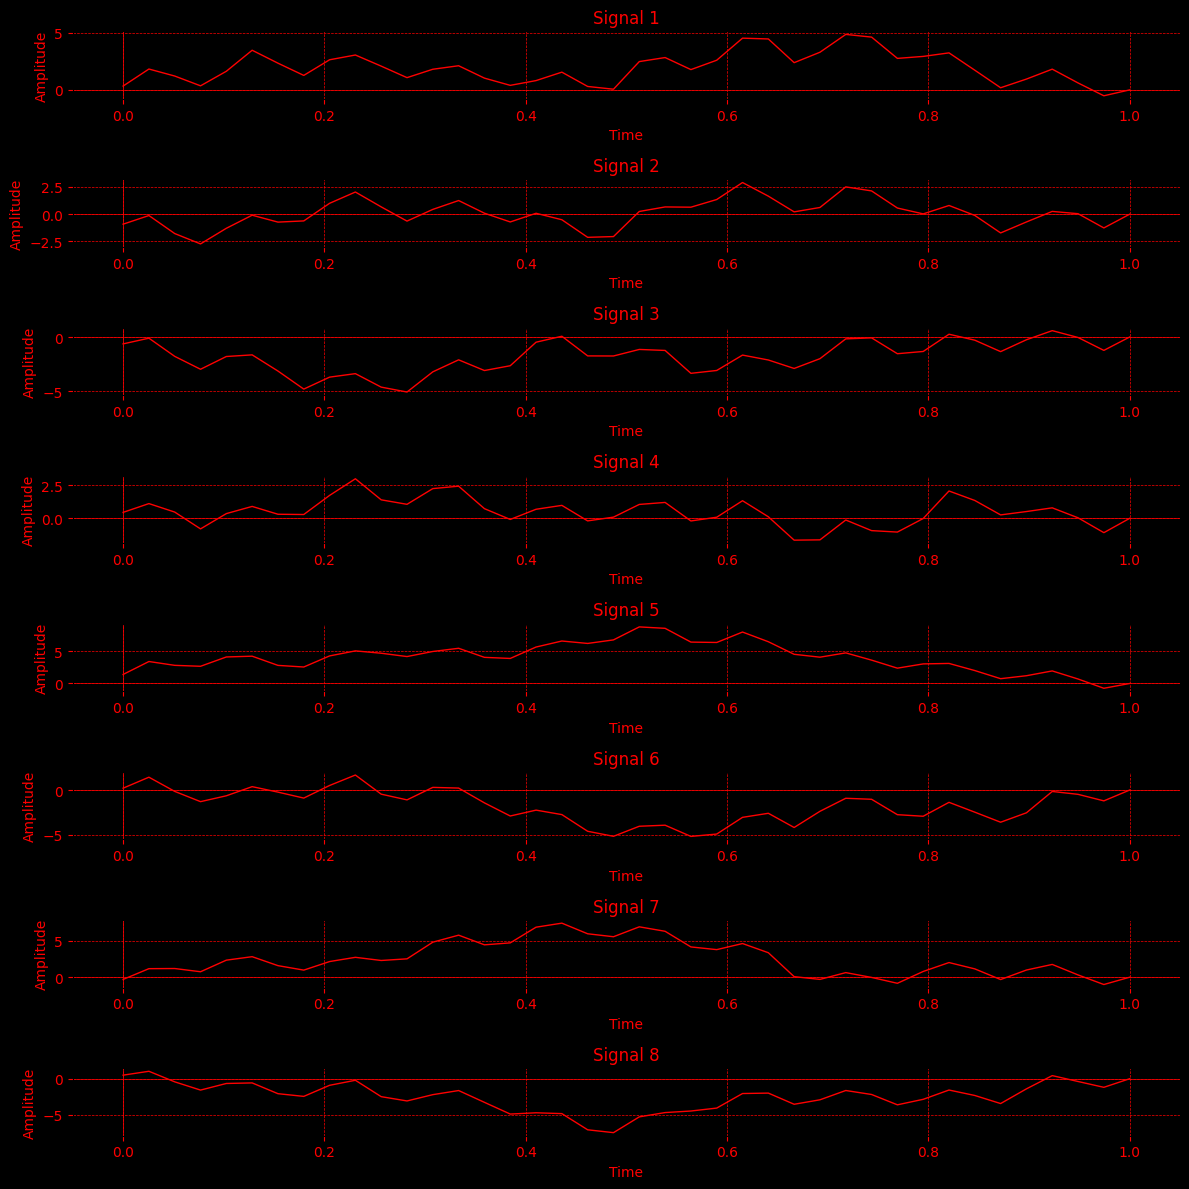

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate an oscillatory sequence (e.g., alpha rhythm)
def generate_oscillatory_sequence(length, frequency, amplitude=1):
    t = np.linspace(0, 1, length)
    oscillatory_sequence = amplitude * np.sin(2 * np.pi * frequency * t)
    return oscillatory_sequence

def generate_fbmn_sequence(length, hurst, initial_scale, seed=None):
    if seed is not None:
        seed = int(seed)  # Convert the seed to an integer
        np.random.seed(seed)

    # Create an empty array to store the fBm sequence
    fbmn = np.zeros(length+1)

    # Initialize endpoints
    fbmn[0] = 0
    fbmn[length] = 0

    def midpoint_displacement(left, right, scale):
        if right - left <= 1:
            return

        mid = (left + right) // 2

        # Calculate midpoint value with a random offset
        fbmn[mid] = 0.5 * (fbmn[left] + fbmn[right]) + scale * (np.random.rand() - 0.5)

        # Recursively apply midpoint displacement to the left and right segments
        midpoint_displacement(left, mid, scale / 2)
        midpoint_displacement(mid, right, scale / 2)

    midpoint_displacement(0, length, initial_scale)

    # Calculate the final fBm sequence by taking differences
    fbmn_diff = np.diff(fbmn)
    
    # Adjust the scaling by the Hurst exponent
    fbmn_scaled = np.cumsum(fbmn_diff * (2 ** hurst))

    return fbmn_scaled

# Number of signals
num_signals = 8
signal_duration = 40  # Length of each signal

# Create time values for the x-axis
t = np.linspace(0, 1, signal_duration)

# Generate and plot 8 sets of fractal and oscillatory amplitude sequences
fig = plt.figure(figsize=(12, 12))
fig.set_facecolor('black')  # Set the background color of the entire figure to black

for i in range(num_signals):
    # Generate amplitude sequences for each signal
    fractal_amplitude = generate_fbmn_sequence(signal_duration, 1, 8, seed=i)  # Hurst exponent of 0.8 for fractal amplitude
    oscillatory_amplitude = generate_oscillatory_sequence(signal_duration, frequency=10, amplitude=1)  # Alpha rhythm (10 Hz)

    ax = plt.subplot(num_signals, 1, i+1)
    ax.plot(t, fractal_amplitude + oscillatory_amplitude, color='red', linewidth=1.0)
    ax.set_title(f'Signal {i+1}', color='red')
    ax.set_xlabel('Time', color='red')
    ax.set_ylabel('Amplitude', color='red')
    ax.tick_params(axis='both', colors='red')
    ax.set_facecolor('black')  # Set the background color of each subplot to black
    
    # Add red x and y-axis lines
    ax.axhline(0, color='red', linewidth=0.5)
    ax.axvline(0, color='red', linewidth=0.5)
    
    # Add a grid
    ax.grid(True, color='red', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
